# Epi - Seurat analysis

In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)
# source('G_lib_TFacts.r')

luz_colors = c('#c466b0', 
               '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))

def_colors = list( reds = luz_colors[13:length(luz_colors) ],
                 yellows = luz_colors[7:12],
                 blues = luz_colors[2:6],
                 greys = c('#e8e8e8', '#b5b5b5', '#a6a6a6') )

col_dot = c('grey90',  brewer.pal(n = 9, name = 'Reds')[7])



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( epithelial = c('EPCAM', 'PAX8', 'EMX2'),
                cycling = c('CDK1', 'MKI67'),
               'Mesonephric Duct GATA3' = c('GATA3', 'TFAP2A'),
               'Mesonephric Duct' = c('FXYD2', 'TFAP2B', 'AMN', 'CUBN', 'SLC3A1'),
                epididymis = c('SPINK2', 'SPAG11B', 'CLDN2'),
                male = c('RPS4Y1'),
               'Mullerian Duct' = c('WNT7A', 'SCGB2A1', 'KRT7', 'KLK11')
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Load processed object

In [42]:
anndataO = readRDS('/nfs/team292/lg18/with_valentina/epithelial.rds')

# Plots supplementary

## metadata

In [43]:
levels(Idents(anndataO) )

[1] "MesoDuct_CUBN"  "MesoDuct_GATA3" "MullDuct"       "Epididymis"

In [44]:
Idents(anndataO) = factor(as.character(Idents(anndataO)), 
                          levels = c('MesoDuct_GATA3','MesoDuct_CUBN', 'Epididymis', 'MullDuct'))

In [45]:
mycolors = c(def_colors$yellows[1:2],   def_colors$blues[1],  def_colors$reds[6])

In [46]:
# DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.3, 
#         cols = mycolors) + 
#         ggtitle('annotated cell states')
# ggsave(filename = paste0('figures-epithelial/0_FS_umap_annotatedLowQC.pdf'), dpi = 300, width = 7.5, height = 5)

In [47]:
# VlnPlot(anndataO, c('scrublet.score'), 
#         pt.size = 0.2,
#         ncol = 1, 
#         cols = mycolors)
# ggsave(filename = paste0('figures-epithelial/0_FS_boxplot_scublet.pdf'), dpi = 300, scale = 0.7)

# VlnPlot(anndataO, c('nCount_RNA'), 
#         pt.size = 0.2,
#         ncol = 1, 
#         cols = mycolors)
# ggsave(filename = paste0('figures-epithelial/0_FS_boxplot_nCount_RNA.pdf'), dpi = 300, scale = 0.7)

# TF-IDF markers in high resolution populations

In [48]:
# df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters, N = 100000)
# dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-epithelial/0_FS_table_TFIDF_annotatedLowQC.csv', quote = F, row.names = F)

# df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
# DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
#   group_by(cluster) %>%
#   group_map(~ head(.x, 15L)$gene) %>%
#   unlist(.)

In [49]:
# DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis() + scale_fill_brewer(palette = 'Reds') +
# ggsave(filename = paste0('figures-epithelial/0_FS_dotplot_TFIDF_annotatedLowQC.pdf'), dpi = 75, height = 5, width = 45)

# Exclude non-confident cells

## Plots

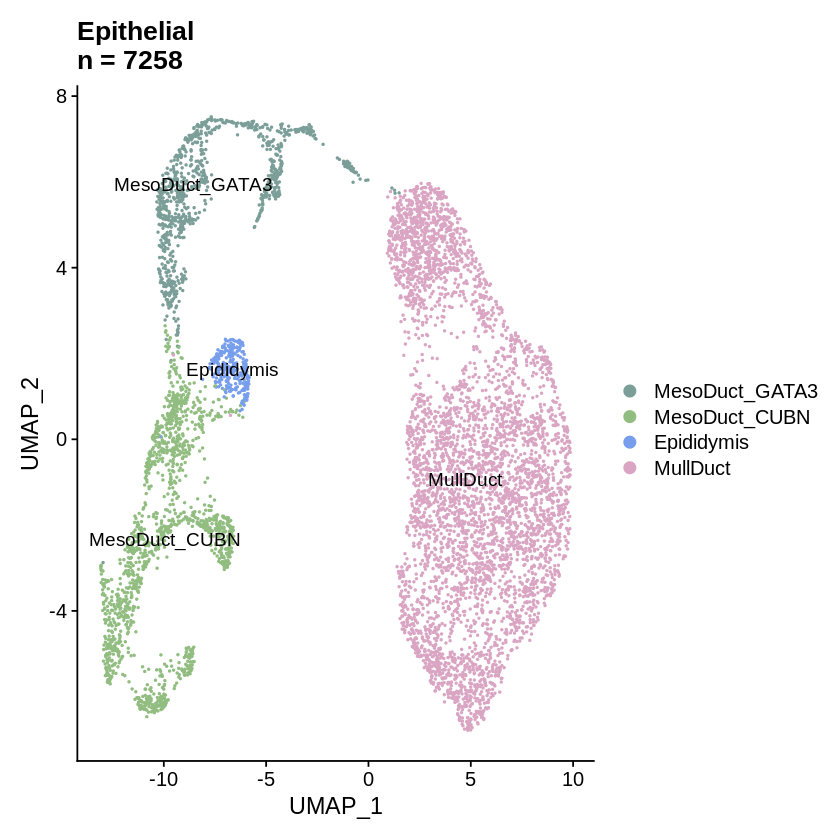

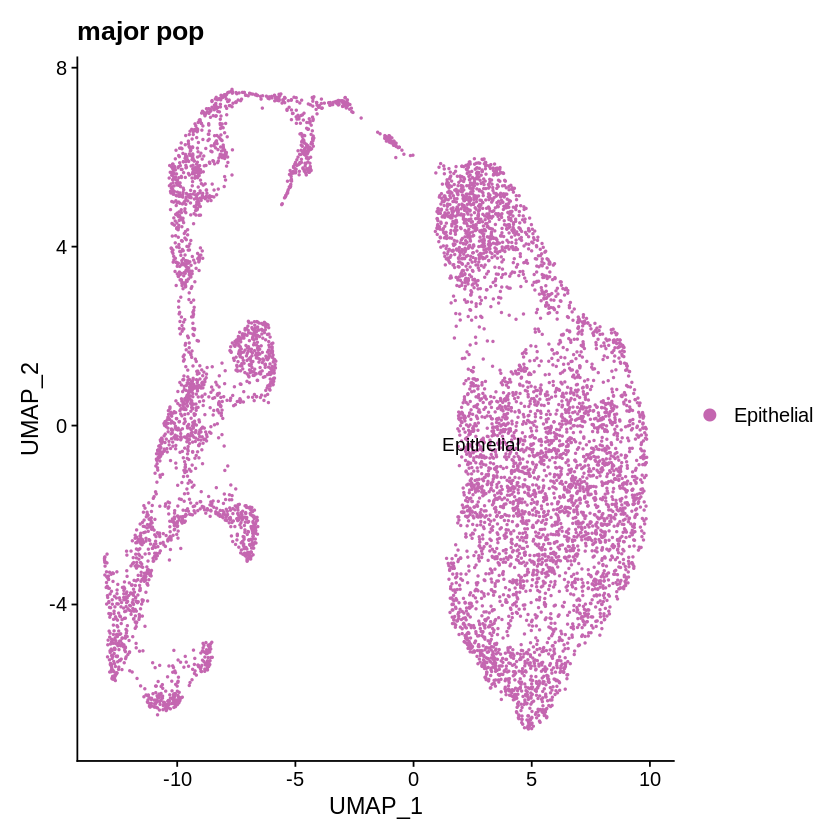

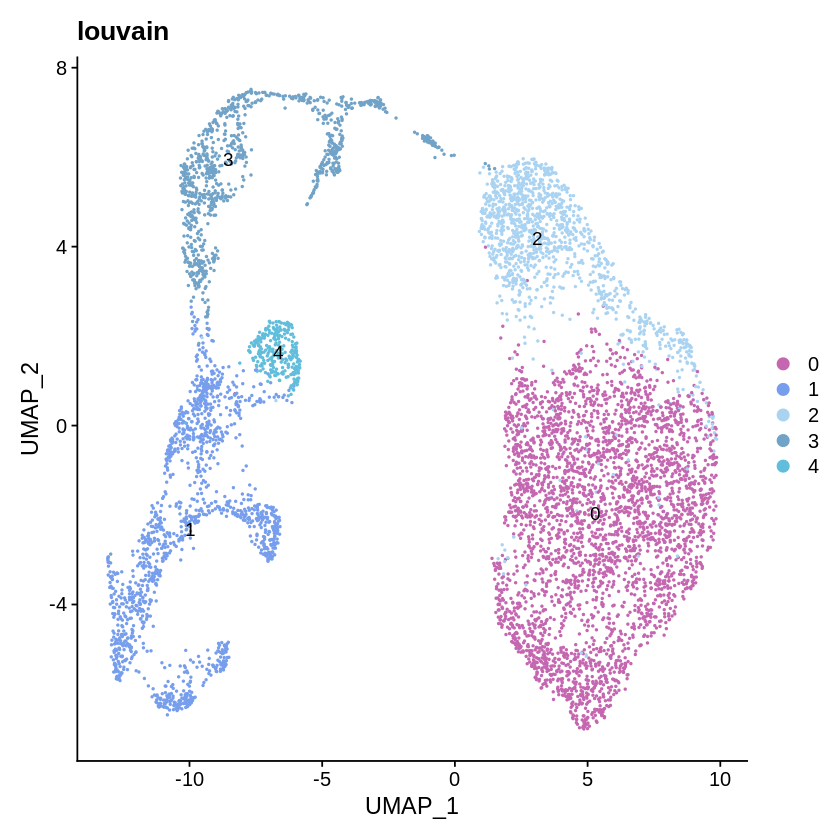

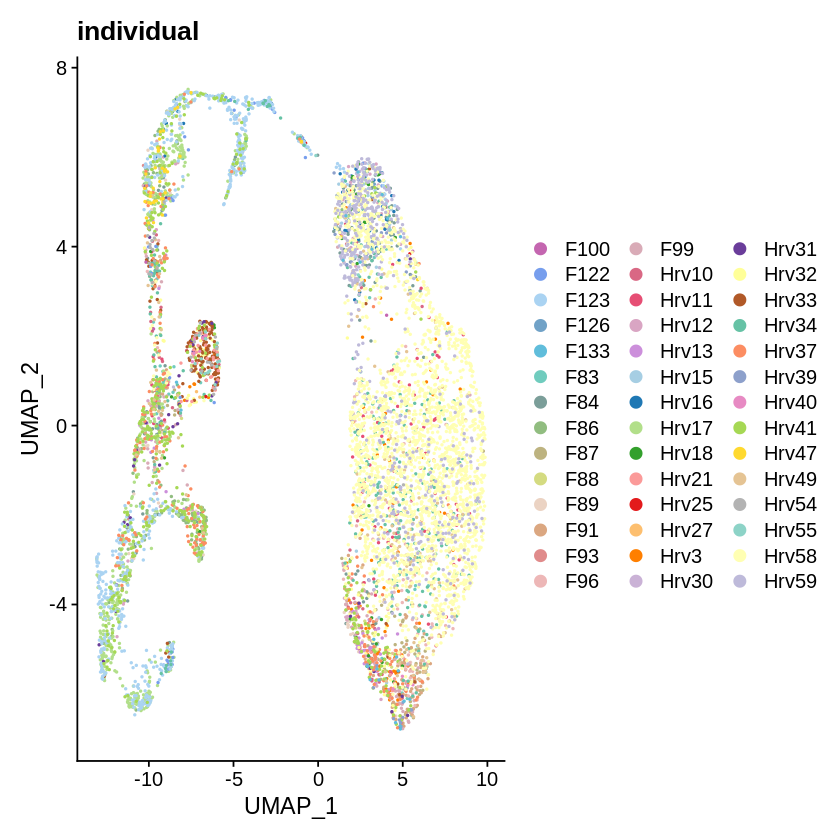

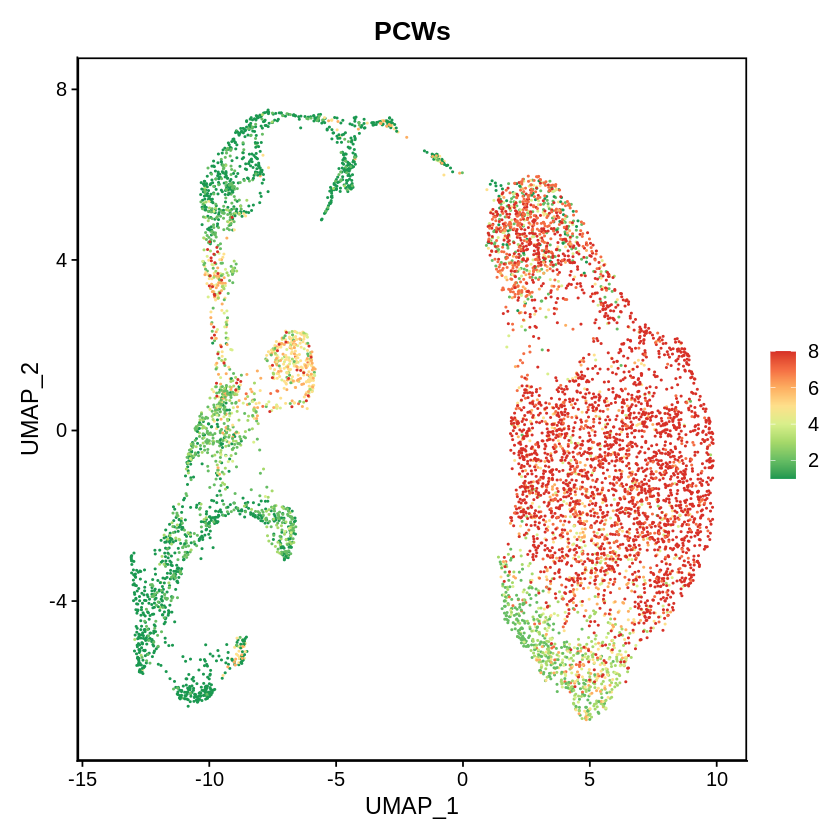

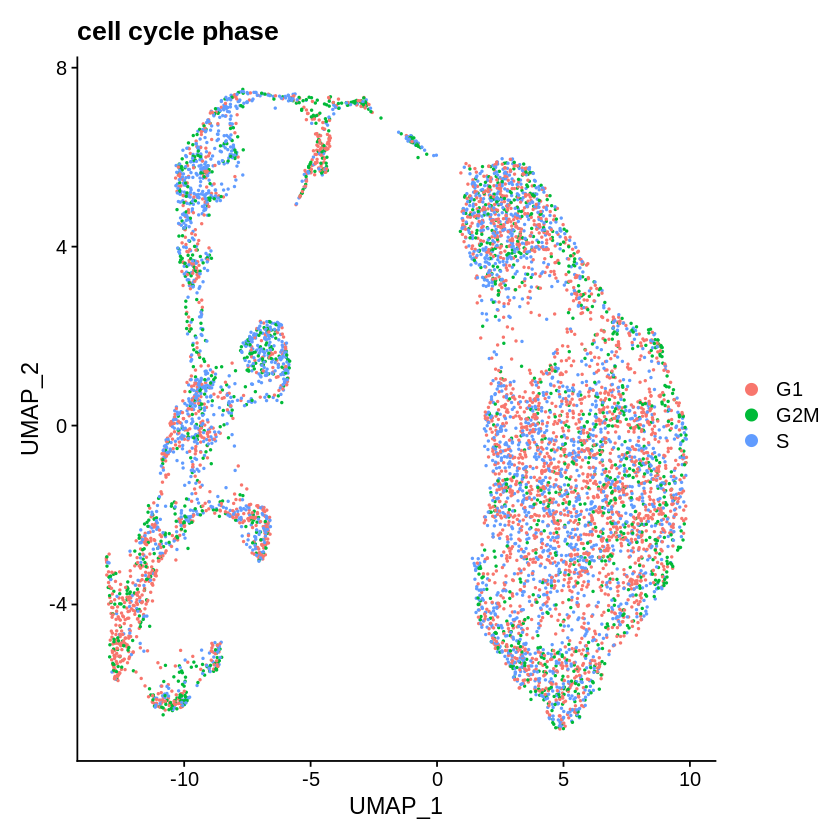

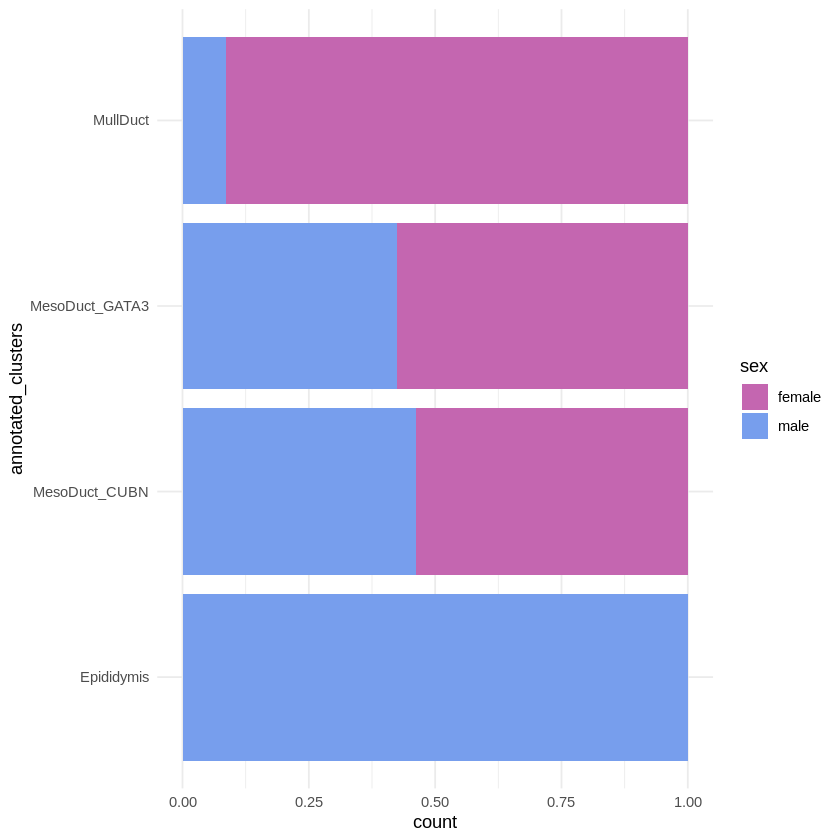

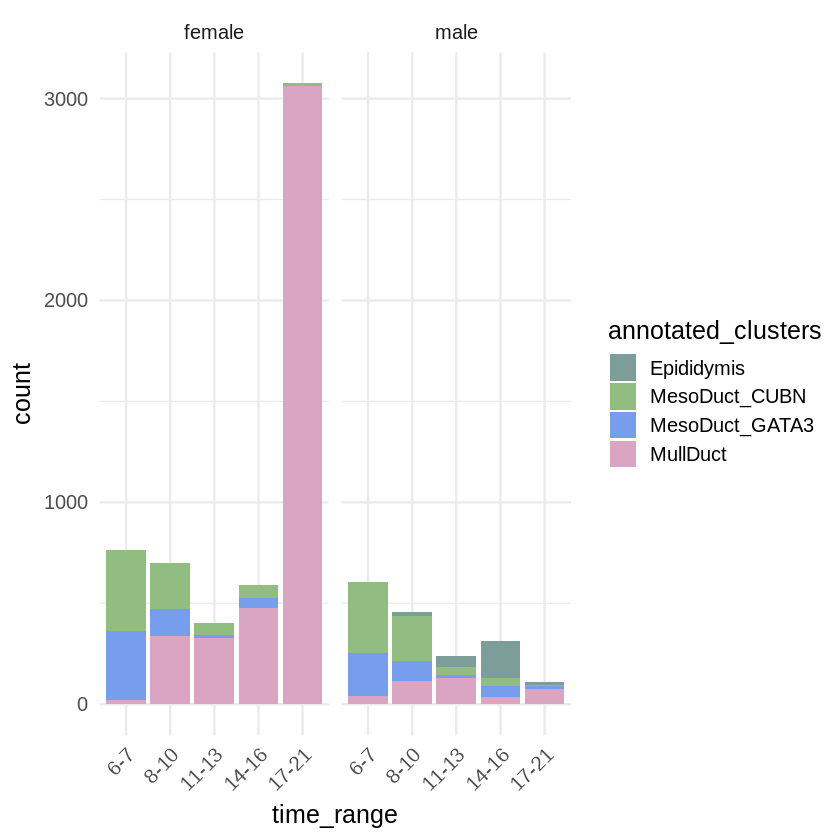

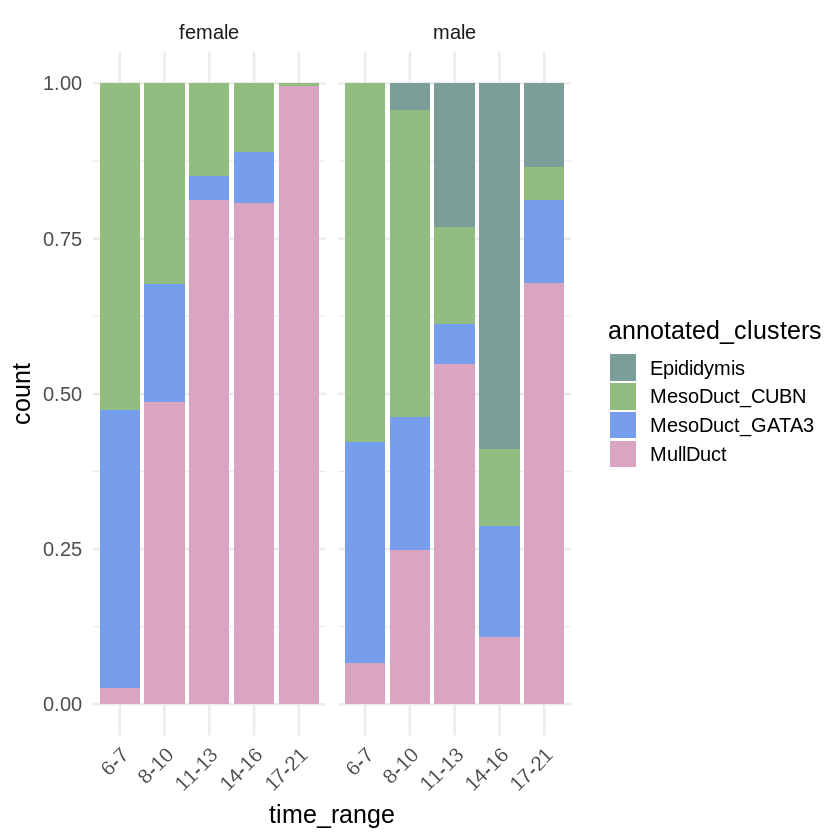

In [50]:
DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.3, 
        cols = mycolors) + 
        ggtitle(paste0('Epithelial\nn = ', ncol(anndataO)))
ggsave(filename = paste0('figures-epithelial/0_FS_umap_annotated.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'clusters', label = T, cols = colors, pt.size =0.3) + ggtitle('major pop')
ggsave(filename = paste0('figures-epithelial/0_FS_umap_majorpop.pdf'), dpi = 300, width = 6, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'seurat_clusters', label = T, cols = colors, pt.size =0.3) + ggtitle('louvain')
ggsave(filename = paste0('figures-epithelial/0_FS_umap_louvain.pdf'), dpi = 300, width = 6, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'individual', label = F, cols = colors, pt.size =0.3) + ggtitle('individual')
ggsave(filename = paste0('figures-epithelial/0_FS_umap_individual.pdf'), dpi = 300, width = 6, height = 5)

FeaturePlot(anndataO, reduction = "umap", features = 'PCW', pt.size =0.2, cols = rev(brewer.pal(n = 8, name = 'RdYlGn')) ) + 
    ggtitle('PCWs') + 
   theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-epithelial/0_FS2_umap_PCWs.pdf'), dpi = 300, width = 5.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'Phase', pt.size =0.3) + ggtitle('cell cycle phase')
ggsave(filename = paste0('figures-epithelial/0_FS_umap_cellcyclephase.pdf'), dpi = 300, width = 6, height = 5)


ggplot(anndataO@meta.data, aes(x=annotated_clusters, fill = sex) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = luz_colors) +
    theme_minimal()
ggsave(filename = paste0('figures-epithelial/0_FS_barplot_sex.pdf'), dpi = 300, width = 6, height = 5)


anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
#     geom_bar(position = 'fill')+
    geom_bar()+
    theme_minimal(15) + theme(axis.text.x = element_text(angle = 45, hjust=1))
ggsave(filename = paste0('figures-epithelial/0_FS2_barplot_PCWs_sex.pdf'), dpi = 300, width = 5.5, height = 4.5)

ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_minimal(15) + theme(axis.text.x = element_text(angle = 45, hjust=1))
ggsave(filename = paste0('figures-epithelial/0_FS2_barplot_PCWs_sexII.pdf'), dpi = 300, width = 5.5, height = 4.5)

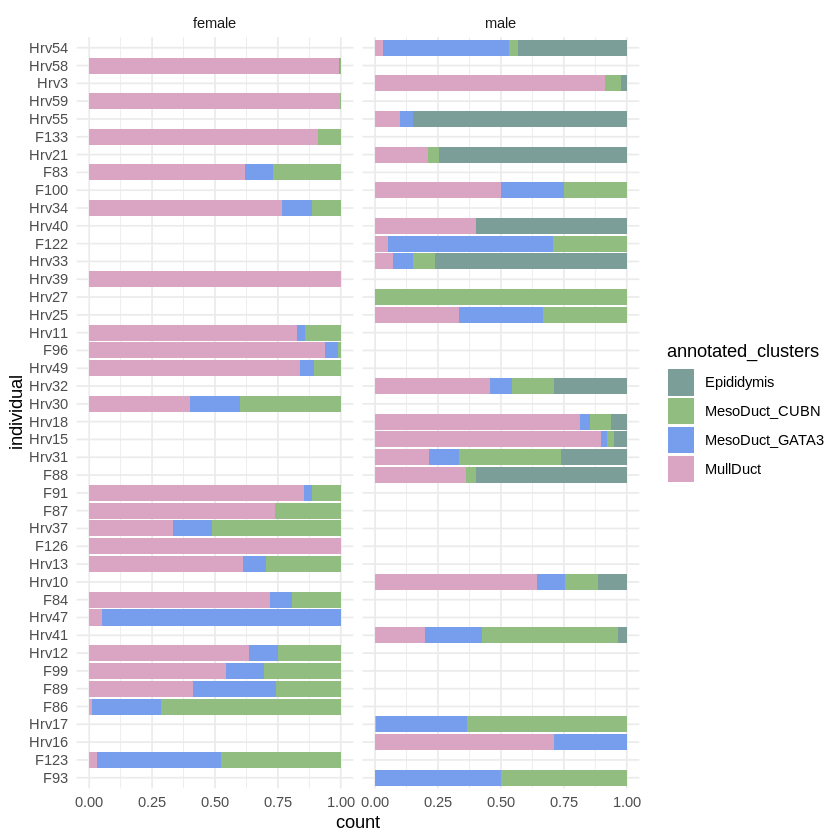

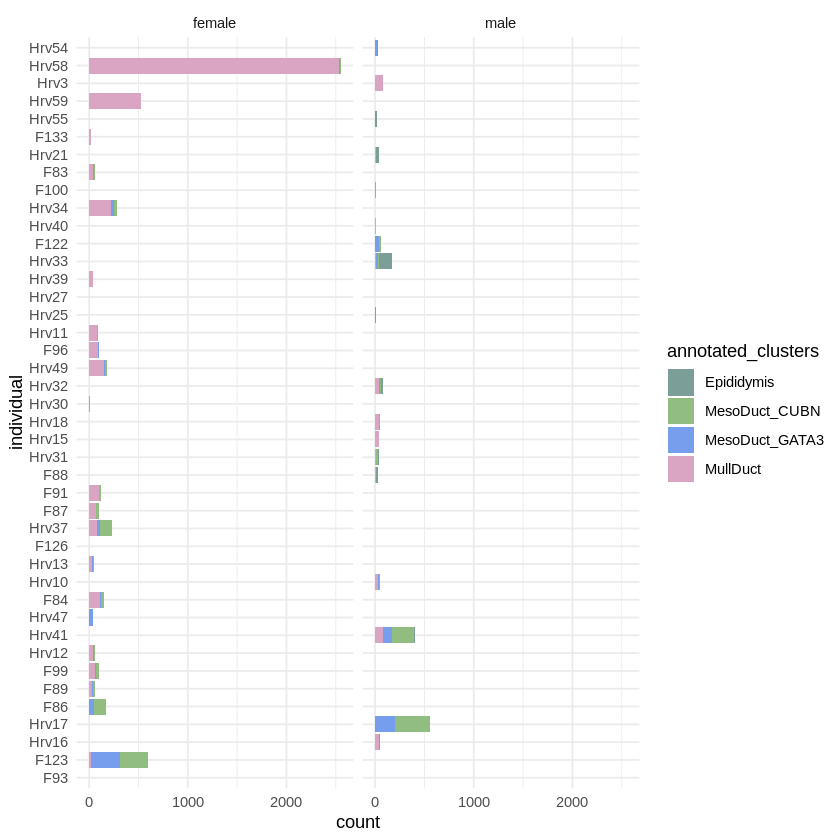

In [51]:
anndataO@meta.data$individual = factor(anndataO@meta.data$individual, levels = unique(anndataO@meta.data$individual[ order(anndataO@meta.data$PCW) ]))
ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    theme_minimal()
ggsave(filename = paste0('figures-epithelial/0_FS2_barplot_individuals_sex.pdf'), dpi = 300, width = 7, height = 5.5)

ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar() + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    theme_minimal()
ggsave(filename = paste0('figures-epithelial/0_FS2_barplot_individuals_sexII.pdf'), dpi = 300, width = 7, height = 5.5)

# Known markers

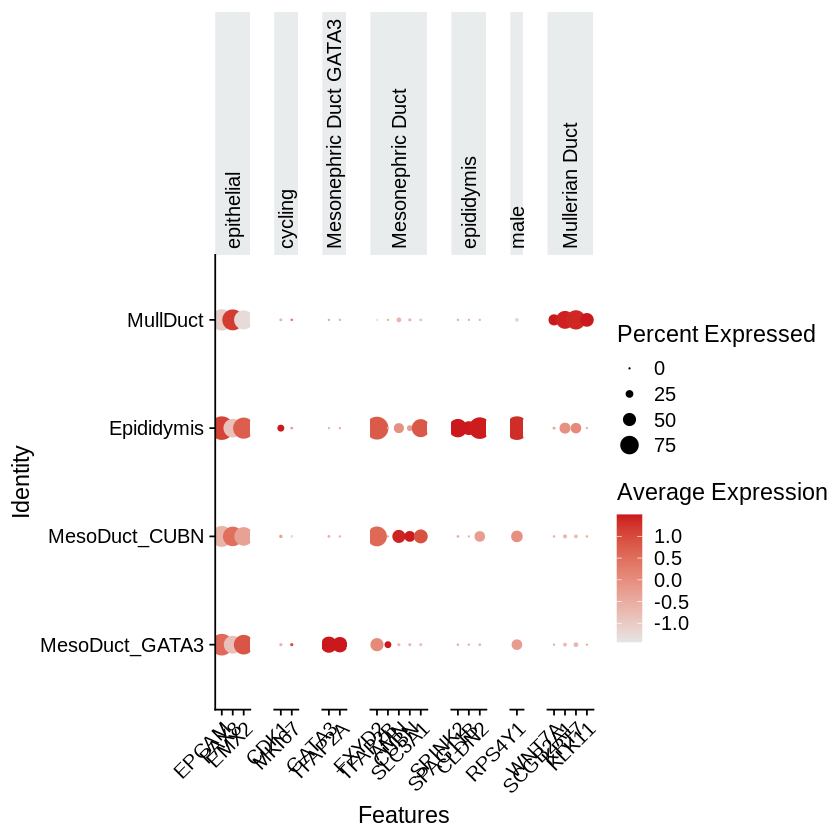

In [52]:
DotPlot(anndataO, features = markers, cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-epithelial/0_F_dotplot_markers.pdf'), dpi = 75, height = 4, width = 10)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



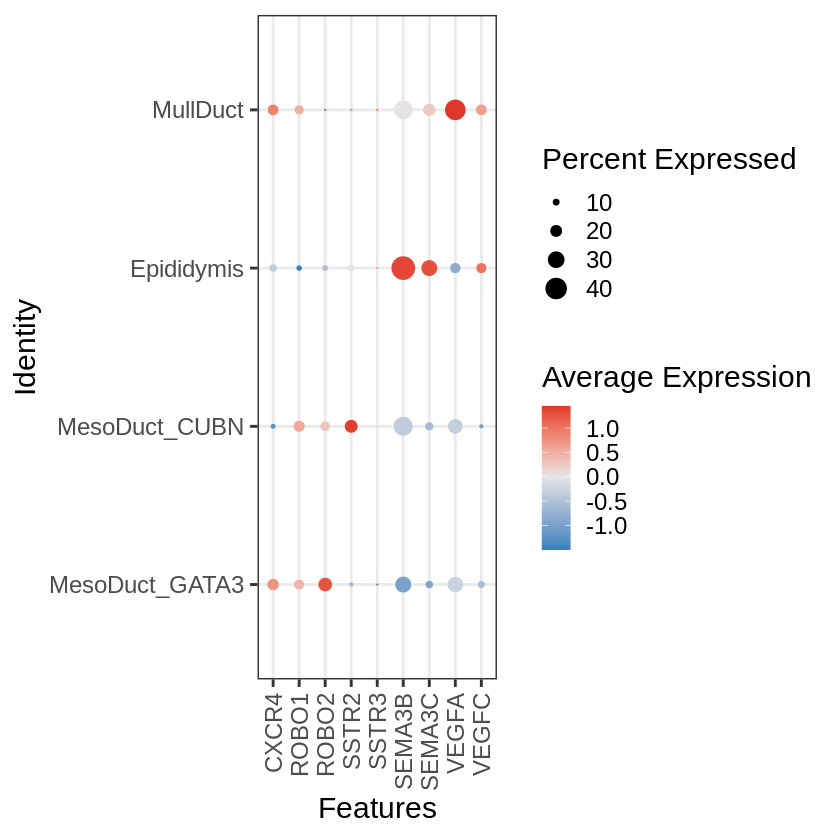

In [53]:
# DotPlot(anndataO, features = c('CXCR4',  'ROBO1', 'ROBO2', 'SSTR3', 'SEMA3B','SEMA3C', 'VEGFA', 'VEGFC', 'TMEM219'))  +  
x = subset(anndataO, cells = Cells(anndataO)[ anndataO$annotated_clusters != 'Epi_cycling' ] )
DotPlot(x, features = c('CXCR4',  'ROBO1', 'ROBO2', 'SSTR2', 'SSTR3', 'SEMA3B','SEMA3C', 'VEGFA', 'VEGFC'))  +  
    scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                          high = brewer.pal(n = 5, name = 'Reds')[4], 
                          mid = 'grey90') + theme_bw(18) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
ggsave(filename = paste0('figures-epithelial/0_F1_dotplot_sPAX8_receptors.pdf'), dpi = 75, height = 2.85, width = 7.5)
ggsave(filename = paste0('figures-epithelial/0_F1_dotplot_sPAX8_receptorsLegend.pdf'), dpi = 75, height = 4, width = 7.5)

## Unbiased markers

### High resolution populations

[1] 4000   10

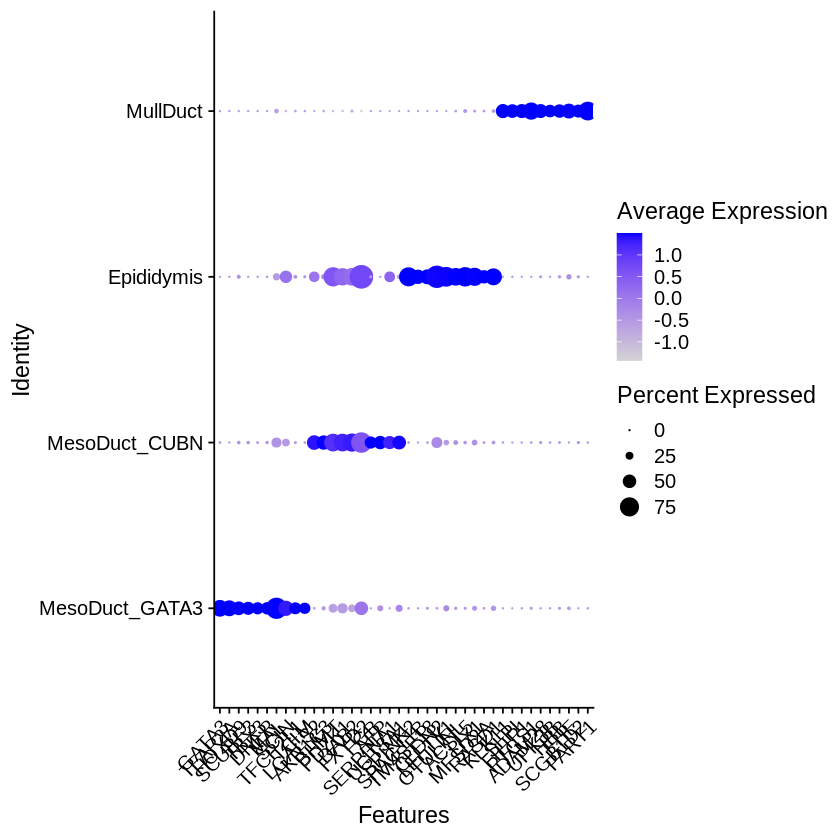

In [58]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 1000)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-epithelial/0_FS_table_TFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(anndataO)) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 10L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-epithelial/0_FS_dotplot_TFIDF_annotated.pdf'), dpi = 75, height = 5, width = 25)